# OCR Cookbook

---

## OCR Exploration and Structured Outputs
In this cookbook, we will explore the basics of OCR and leverage it together with existing models to achieve structured outputs fueled by our OCR model.

You may want to do this in case current vision models are not powerful enough, hence enhancing their vision OCR capabilities with the OCR model to achieve better structured data extraction.

---

### Model Used
- Mistral OCR
- Pixtral 12B & Ministral 8B


## Setup

First, let's install `mistralai` and download the required files.

In [35]:
%%capture
!pip install mistralai

### Download PDF and image files

In [36]:
%%capture
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png

## Mistral OCR with PDF

We will need to set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [37]:
# Initialize Mistral client with API key
from mistralai import Mistral

api_key = "gxoOAIKmRj6Q47djZwjPPAiw5ReqyaFZ" # Replace with your API key
client = Mistral(api_key=api_key)

There are two types of files you can apply OCR to:
- 1. PDF files
- 2. Image files

Let's start with a PDF file:

In [51]:
# Import required libraries
from pathlib import Path
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

# Verify PDF file exists
pdf_file = Path("C.D6.00.101.00-A0÷V·CTO._COCHE_M2·H1I.pdf")
assert pdf_file.is_file()

# Upload PDF file to Mistral's OCR service
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

# Get URL for the uploaded file
signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

# Process PDF with OCR, including embedded images
pdf_response = client.ocr.process(
    document=DocumentURLChunk(document_url=signed_url.url),
    model="mistral-ocr-latest",
    include_image_base64=True
)

# Convert response to JSON format
response_dict = json.loads(pdf_response.model_dump_json())

print(json.dumps(response_dict, indent=4)[0:2000]) # check the first 1000 characters

{
    "pages": [
        {
            "index": 0,
            "markdown": "![img-0.jpeg](img-0.jpeg)",
            "images": [
                {
                    "id": "img-0.jpeg",
                    "top_left_x": 80,
                    "top_left_y": 79,
                    "bottom_right_x": 3926,
                    "bottom_right_y": 2745,
                    "image_base64": "


In [50]:
pdf_response

AttributeError: 'OCRResponse' object has no attribute 'markdown'

View the result with the following:

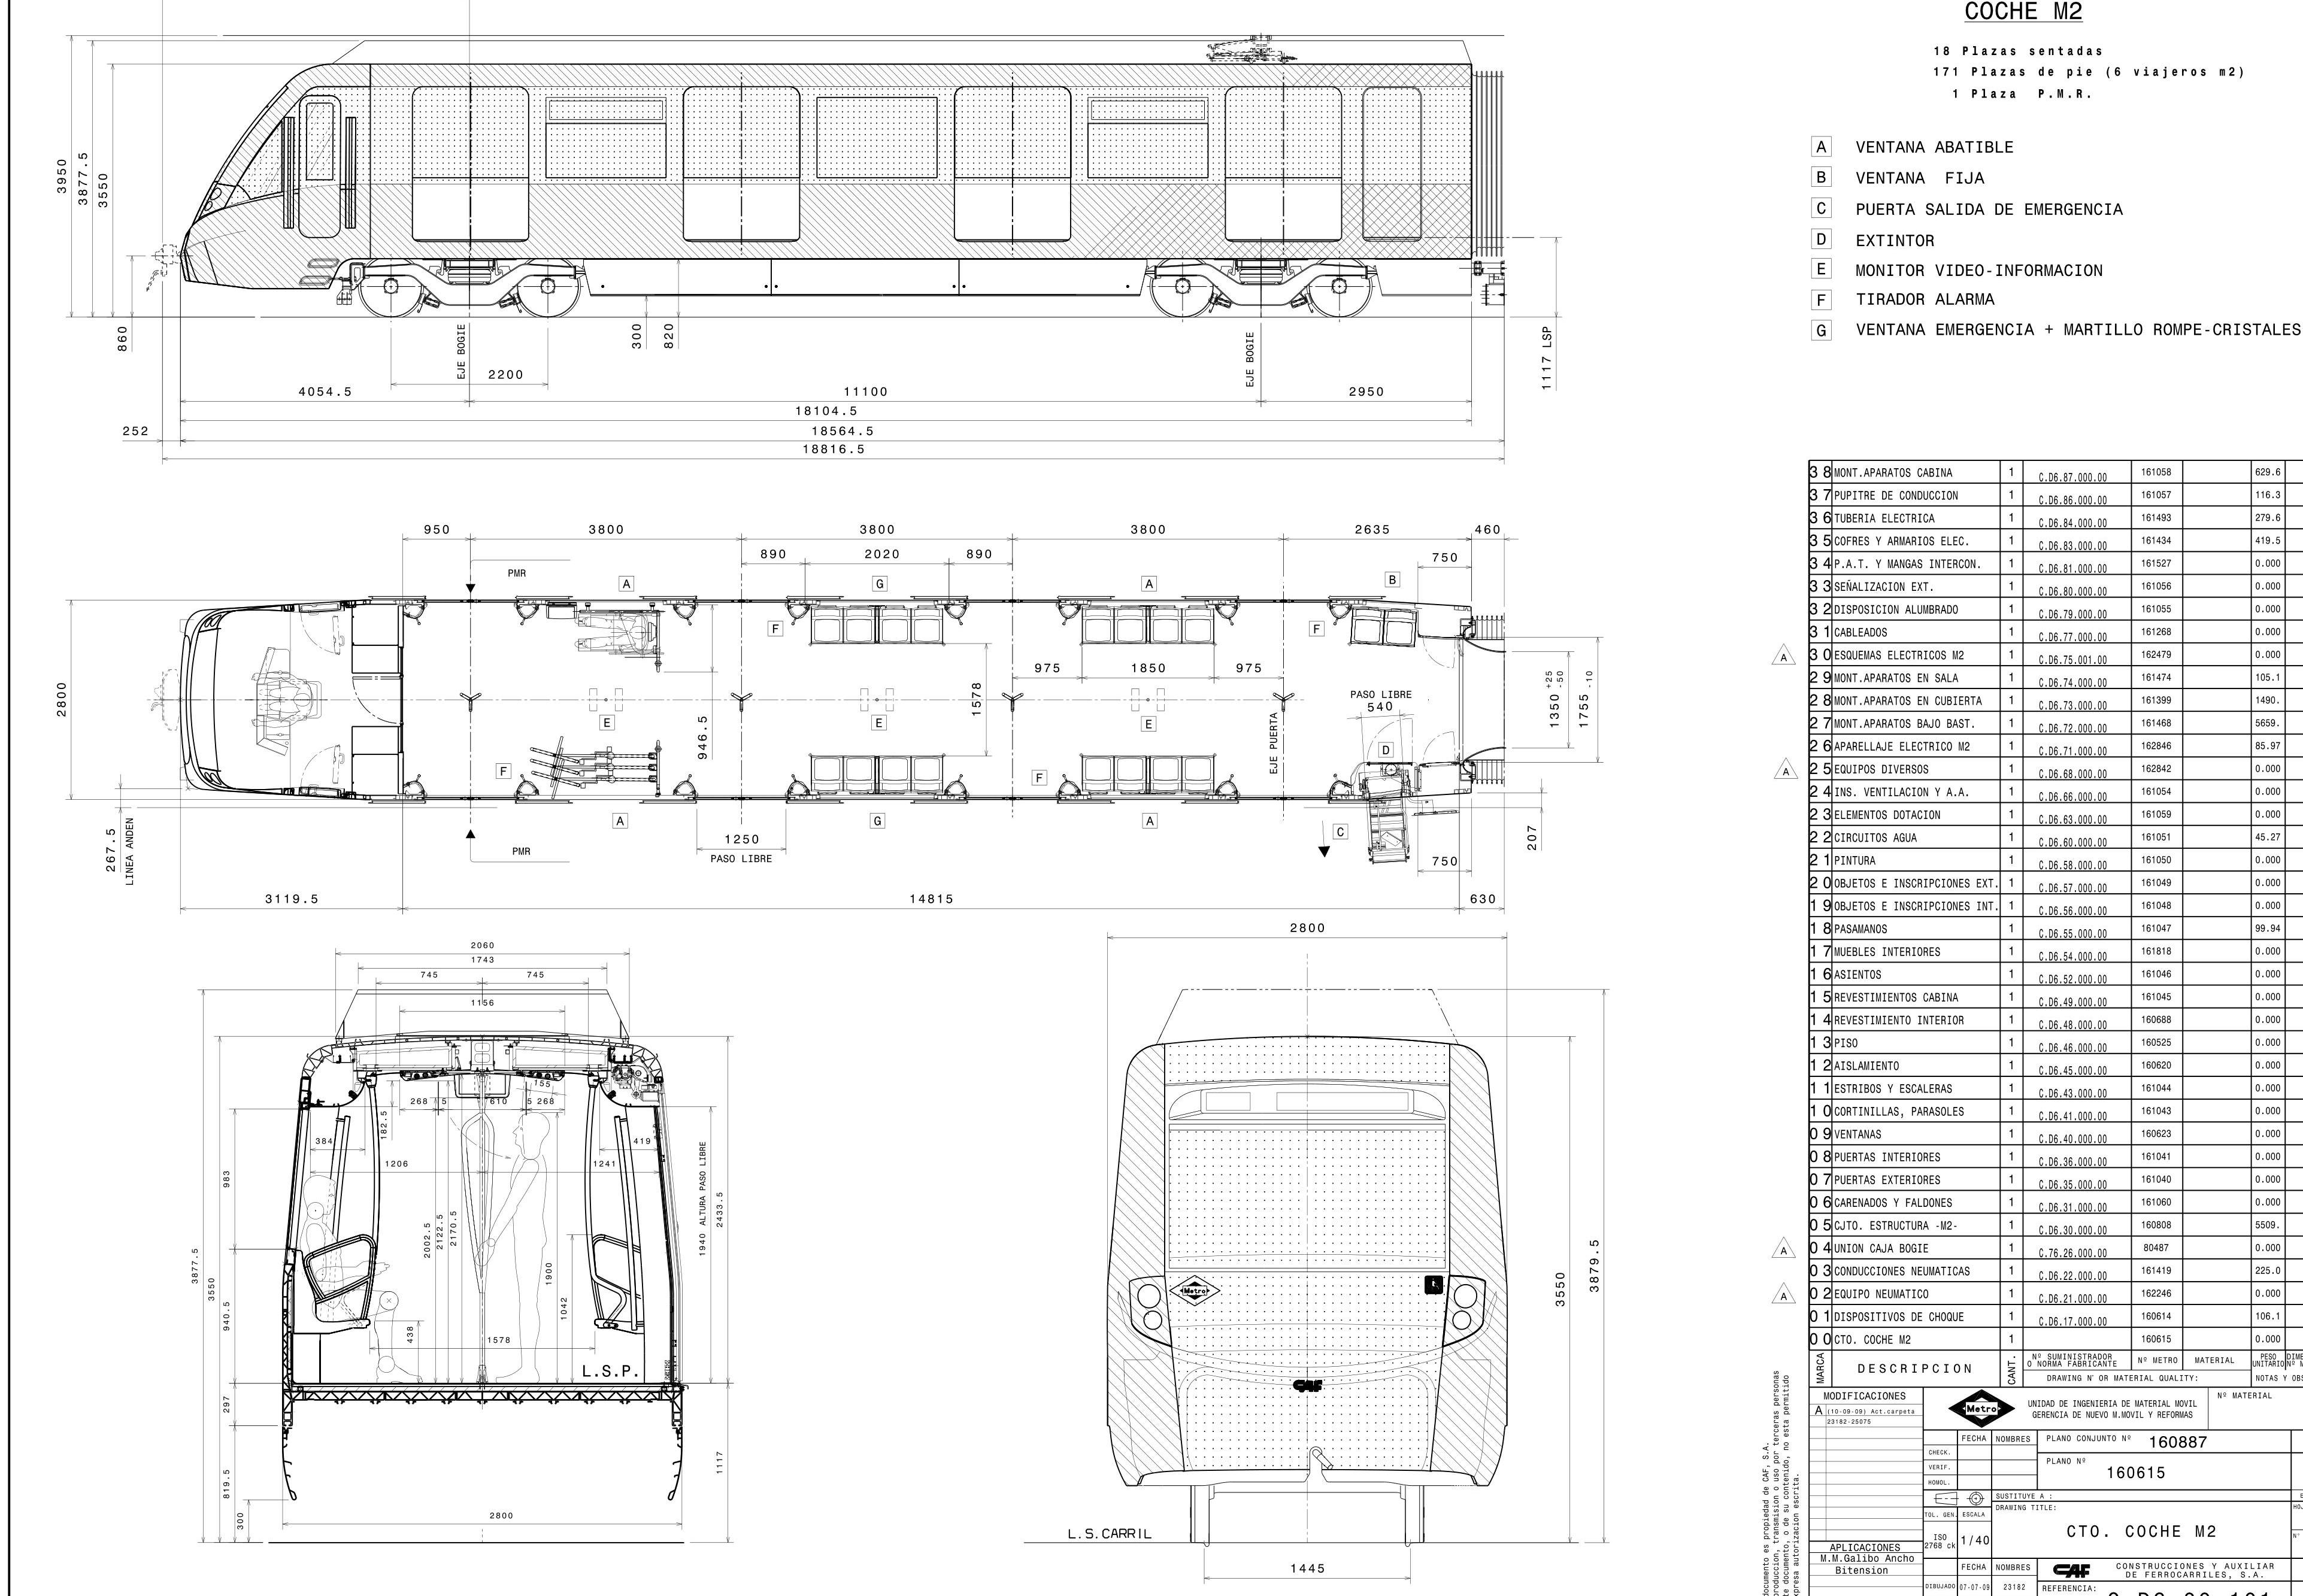

In [47]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.

    Args:
        markdown_str: Markdown text containing image placeholders
        images_dict: Dictionary mapping image IDs to base64 strings

    Returns:
        Markdown text with images replaced by base64 data
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(
            f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
        )
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
    """
    Combine OCR text and images into a single markdown document.

    Args:
        ocr_response: Response from OCR processing containing text and images

    Returns:
        Combined markdown string with embedded images
    """
    markdowns: list[str] = []
    # Extract images from page
    for page in ocr_response.pages:
        image_data = {}
        for img in page.images:
            image_data[img.id] = img.image_base64
        # Replace image placeholders with actual images
        markdowns.append(replace_images_in_markdown(page.markdown, image_data))

    return "\n\n".join(markdowns)

# Display combined markdowns and images
display(Markdown(get_combined_markdown(pdf_response)))

## Mistral OCR with Image

In addition to the PDF file shown above, Mistral OCR can also process image files:

In [40]:
import base64

# Verify image exists
image_file = Path("receipt.png")
assert image_file.is_file()

# Encode image as base64 for API
encoded = base64.b64encode(image_file.read_bytes()).decode()
base64_data_url = f"data:image/jpeg;base64,{encoded}"

# Process image with OCR
image_response = client.ocr.process(
    document=ImageURLChunk(image_url=base64_data_url),
    model="mistral-ocr-latest"
)

# Convert response to JSON
response_dict = json.loads(image_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "pages": [
        {
            "index": 0,
            "markdown": "# PLACE FACE UP ON DASH <br> CITY OF PALO ALTO <br> NOT VALID FOR ONSTREET PARKING \n\nExpiration Date/Time 11:59 PM\n\nAUG 19, 2024\n\nPurchase Date/Time: 01:34pm Aug 19, 2024\nTotal Due: $\\$ 15.00$\nRate: Daily Parking\nTotal Paid: $\\$ 15.00$\nPmt Type: CC (Swipe)\nTicket \\#: 00005883\nS/N \\#: 520117260957\nSetting: Permit Machines\nMach Name: Civic Center\n\\#^^^^-1224, Visa\nDISPLAY FACE UP ON DASH\n\nPERMIT EXPIRES\nAT MIDNIGHT",
            "images": [],
            "dimensions": {
                "dpi": 200,
                "height": 3210,
                "width": 1806
            }
        }
    ],
    "model": "mistral-ocr-2503-completion",
    "usage_info": {
        "pages_processed": 1,
        "doc_size_bytes": 3110191
    }
}


## Extract structured data from OCR results

OCR results can be further processed using another model.

Our goal is to extract structured data from these results. To achieve this, we will utilize the `pixtral-12b-latest` model, supported by our OCR model, to deliver better and higher-quality answers:

In [41]:
# Get OCR results for processing
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model
chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Parse and return JSON response
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))

{
    "parking_receipt": {
        "instructions": "PLACE FACE UP ON DASH",
        "city": "CITY OF PALO ALTO",
        "validity": "NOT VALID FOR ONSTREET PARKING",
        "expiration": {
            "date": "AUG 19, 2024",
            "time": "11:59 PM"
        },
        "purchase": {
            "date": "Aug 19, 2024",
            "time": "01:34pm"
        },
        "amounts": {
            "total_due": "$15.00",
            "total_paid": "$15.00"
        },
        "rate": "Daily Parking",
        "payment_type": "CC (Swipe)",
        "ticket_number": "00005883",
        "serial_number": "520117260957",
        "settings": {
            "type": "Permit Machines",
            "machine_name": "Civic Center"
        },
        "card_details": {
            "card_number": "^^^^-1224",
            "type": "Visa"
        },
        "expiry_message": "PERMIT EXPIRES AT MIDNIGHT"
    }
}


In the example above, we are leveraging a model already capable of vision tasks.

However, we could also use text-only models for the structured output. Note in this case, we do not include the image in the user message:

In [42]:
# Get OCR results for processing
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model
chat_response = client.chat.complete(
    model="ministral-8b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Parse and return JSON response
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))


{
    "expiration_date_time": "11:59 PM",
    "expiration_date": "AUG 19, 2024",
    "purchase_date_time": "01:34pm Aug 19, 2024",
    "total_due": 15.0,
    "rate": "Daily Parking",
    "total_paid": 15.0,
    "payment_type": "CC (Swipe)",
    "ticket_number": "00005883",
    "serial_number": "520117260957",
    "setting": "Permit Machines",
    "machine_name": "Civic Center",
    "card_number": "1224, Visa"
}


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## All Together - Mistral OCR + Custom Structured Output
Let's design a simple function that takes an `image_path` file and returns a JSON structured output in a specific format. In this case, we arbitrarily decided we wanted an output respecting the following:

```python
class StructuredOCR:
    file_name: str  # can be any string
    topics: list[str]  # must be a list of strings
    languages: str  # string
    ocr_contents: dict  # any dictionary, can be freely defined by the model
```

We will make use of [custom structured outputs](https://docs.mistral.ai/capabilities/structured-output/custom_structured_output/).

In [54]:
from enum import Enum
from pathlib import Path
from pydantic import BaseModel
import base64
from typing import TypedDict
from typing import List, Literal, Dict
from typing_extensions import TypedDict

class OCRContents(TypedDict):
    modificaciones: str
    referencia: str
    matricula: str
    plano_conjunto_n: int
    plano_n: int

class StructuredOCR(BaseModel):
    file_name: str
    topics: list[str]
    languages: str
    ocr_contents: OCRContents




def structured_ocr(image_path: str) -> StructuredOCR:
    """
    Process an image using OCR and extract structured data.

    Args:
        image_path: Path to the image file to process

    Returns:
        StructuredOCR object containing the extracted data

    Raises:
        AssertionError: If the image file does not exist
    """
    # Validate input file
    image_file = Path(image_path)
    assert image_file.is_file(), "The provided image path does not exist."

    # Read and encode the image file
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    # Process the image using OCR
    image_response = client.ocr.process(
        document=ImageURLChunk(image_url=base64_data_url),
        model="mistral-ocr-latest"
    )
    image_ocr_markdown = image_response.pages[0].markdown

    # Parse the OCR result into a structured JSON response
    chat_response = client.chat.parse(
        model="pixtral-12b-latest",
        messages=[
            {
                "role": "user",
                "content": [
                    ImageURLChunk(image_url=base64_data_url),
                    TextChunk(text=(
                        f"This is the image's OCR in markdown:\n{image_ocr_markdown}\n.\n"
                        "Convert this into a structured JSON response "
                        "with the OCR contents in a sensible dictionnary."
                        )
                    )
                ]
            }
        ],
        response_format=StructuredOCR,
        temperature=0
    )

    return chat_response.choices[0].message.parsed

We can now extract structured output from any image parsed with our OCR model.

In [56]:
# Example usage
image_path = "test_metro_madrid2.png" # Path to sample receipt image
structured_response = structured_ocr(image_path) # Process image and extract data

# Parse and return JSON response
response_dict = json.loads(structured_response.model_dump_json())
print(json.dumps(response_dict, indent=4))

{
    "file_name": "img-0.jpeg",
    "topics": [
        "Matricula",
        "Modificaciones",
        "Plano Conjunto N",
        "Plano N",
        "Referencia"
    ],
    "languages": "Spanish",
    "ocr_contents": {
        "modificaciones": "T 17/03/24 4 BIS/NUEWN",
        "referencia": "ADTranz",
        "matricula": "3EKD100391",
        "plano_conjunto_n": 65845,
        "plano_n": 65843
    }
}


The original image for comparison can be found below.

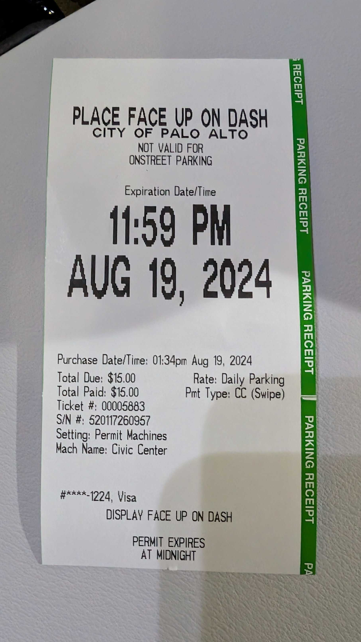

In [ ]:
from PIL import Image

image = Image.open(image_path)
image.resize((image.width // 5, image.height // 5))
